In [106]:
from astropy import units as u
from astropy import time
import astropy
import numpy as np

from poliastro import iod
from poliastro.bodies import Body,Mars, Earth, Venus, Jupiter, Saturn, Uranus, Neptune, Sun, Europa, Ganymede, Callisto, Io, Titan
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.frames import Planes
from poliastro.frames.fixed import JupiterFixed
from poliastro.frames.equatorial import JupiterICRS
from astroquery.jplhorizons import Horizons
from copy import deepcopy

from scipy import ndimage
from scipy.spatial.transform import Rotation as scipyRot
from collections import defaultdict
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math
import matplotlib.pyplot as plt
# More info: https://plotly.com/python/renderers/
import plotly.io as pio
from poliastro.util import norm, time_range
pio.renderers.default = "plotly_mimetype+notebook_connected"
import weakref
from astropy.coordinates import solar_system_ephemeris
from collections.abc import Mapping
from poliastro.extra_util import get_galilean_orbs, ecliptic_slingshot, get_galilean_ephemerides
#from poliastro.extra_util import get_single_burn_elliptical_hohmann
solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [107]:
start_date= time.Time("2037-06-11 00:01", scale="utc").tdb
end_date= time.Time("2037-09-21 00:01", scale="utc").tdb
epochs=time_range(start=start_date,end=end_date,periods=50)

callisto_ephem = Ephem.from_horizons(504,epochs= epochs, attractor= Jupiter,plane=Planes.EARTH_ECLIPTIC)#Callisto is 504
callisto_orb= Orbit.from_ephem(attractor=Jupiter,ephem=callisto_ephem,epoch=start_date)


r_perijove = Jupiter.R+230000 * u.km
r_apijove = Jupiter.R+6.5e6*u.km
a_start = (r_perijove+r_apijove)/2
ecc_start = (r_perijove-r_apijove)/(r_perijove+r_apijove)

starship_orb=Orbit.from_classical(
Jupiter, a_start, ecc_start, callisto_orb.inc, 
callisto_orb.raan, 0*u.deg, -10*u.deg,
start_date,plane=Planes.EARTH_ECLIPTIC)


print(starship_orb.period.to(u.day))


41.15560137426637 d


/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



In [225]:
print((r_apijove/Jupiter.R.to(u.km)).to(u.one))

91.91926369383987


In [108]:
ephemerides = get_galilean_ephemerides(start_date, end_date)

# # Access like this:
europa_ephem = ephemerides[Europa]
io_ephem = ephemerides[Io]
ganymede_ephem = ephemerides[Ganymede]
callisto_ephem = ephemerides[Callisto]
galilean_orbs = get_galilean_orbs(start_date,start_date+10*u.day)

# Access like this:
europa_orb = galilean_orbs[Europa]
print(europa_orb)


665064 x 676992 km x 2.0 deg orbit around Jupiter (♃) at epoch 2037-06-11 00:02:09.185 (TDB)


In [109]:
europa_orb= Orbit.from_ephem(attractor=Jupiter,ephem=europa_ephem,epoch=start_date)
ganymede_orb= Orbit.from_ephem(attractor=Jupiter,ephem=ganymede_ephem,epoch=start_date)
io_orb= Orbit.from_ephem(attractor=Jupiter,ephem=io_ephem,epoch=start_date) 
callisto_orb= Orbit.from_ephem(attractor=Jupiter,ephem=callisto_ephem,epoch=start_date)

In [110]:
def get_single_burn_elliptical_hohmann(target_orb, initial_orb, min_tof=0.1*u.day, max_tof=50*u.day, tof_step=0.1*u.day, retrograde_only=False):
    time_till_pe=initial_orb.t_p
    periapsis_epoch=initial_orb.epoch+time_till_pe
    
    if max_tof<time_till_pe:
        raise ValueError("Max time of flight is less than time till periapsis, no possible transfers.")
    if min_tof<time_till_pe:
        min_tof=time_till_pe+1*u.s
    # plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
    min_dv=50000*u.m/u.s
    final_orb=None
    final_date=None
    final_burn=None
    final_targ_orb=None
    periapsis_orb=initial_orb.propagate(periapsis_epoch)#Orbit at the first periapsis after start date
    body_orb_placeholder = target_orb.propagate(periapsis_epoch)
    
    max_orbits_before_burn=math.floor((max_tof-time_till_pe)/initial_orb.period)
    for k in range(max_orbits_before_burn):
        pre_burn_orbit=periapsis_orb.propagate(initial_orb.period*k)
        tof_range=np.arange(0,(max_tof.to(u.day)-k*initial_orb.period).value,tof_step.to(u.day).value)*u.day
        for i in range(len(tof_range)):
            arrival_date=periapsis_epoch+tof_range[i]
            body_orb=body_orb_placeholder.propagate(arrival_date+1*u.s)
            #try multiple revolutions of lambert arcs
            for j in range(0,3):
                try:
                    lambert=Maneuver.lambert(periapsis_orb,body_orb,M=j)
                    burn=lambert[0]
                    dv=np.linalg.norm(burn[1])
                    #check for retrograde if needed
                    progradeness=np.dot(burn[1].to(u.km/u.s).value,body_orb.v.to(u.km/u.s).value)
                    if retrograde_only and (progradeness)<0:
                        continue
                
                    if dv<min_dv:
                        min_dv=dv
                        final_orb,dummy=periapsis_orb.apply_maneuver(lambert,intermediate=True)
                        final_date=arrival_date
                        final_burn=burn
                        final_targ_orb=body_orb
                        # plotter.plot(final_orb)
                except Exception as e:
                    # print(e)
                    continue
    
    print("Best dv:", min_dv)
        
    return [min_dv,final_orb,final_targ_orb,final_date,final_burn,time_till_pe,periapsis_orb]

In [111]:
##Incriments spacecraft by tof_step forward and scans over all allowed tofs

def get_single_burn_elliptical_hohmann_brute_force(target_orb, initial_orb,max_depature_wait=50*u.day, min_tof=0.1*u.day, max_tof=50*u.day, tof_step=0.1*u.day, retrograde_only=False,fine_scan=False):
    min_dv=50000*u.m/u.s
    start_epoch=initial_orb.epoch
    final_orb=None
    final_date=None
    final_burn_date=None
    final_targ_orb=None
    final_tof=None
    departure_date_range=np.arange(0,max_depature_wait.to(u.day).value,tof_step.to(u.day).value)*u.day
    tof_range=np.arange(min_tof.to(u.day).value,max_tof.to(u.day).value,tof_step.to(u.day).value)*u.day
    for d in departure_date_range:
        pre_burn_orbit=initial_orb.propagate(d)
        for i in range(len(tof_range)):
            arrival_date=start_epoch+d+tof_range[i]
            body_orb=target_orb.propagate(arrival_date+1*u.s)
            #try multiple revolutions of lambert arcs
            for j in range(0,3):
                try:
                    lambert=Maneuver.lambert(pre_burn_orbit,body_orb,M=j)
                    burn=lambert[0]
                    dv=np.linalg.norm(burn[1])
                    #check for retrograde if needed
                    progradeness=np.dot(burn[1].to(u.km/u.s).value,body_orb.v.to(u.km/u.s).value)
                    if retrograde_only and (progradeness)<0:
                        continue
                
                    if dv<min_dv:
                        min_dv=dv
                        final_orb,dummy=pre_burn_orbit.apply_maneuver(lambert,intermediate=True)
                        final_date=arrival_date
                        final_burn_date=d
                        final_targ_orb=body_orb
                        final_tof=tof_range[i]
                        # plotter.plot(final_orb)
                except Exception as e:
                    # print(e)
                    continue
    results=[min_dv,final_orb,final_targ_orb,final_date,final_burn_date]
    print("Best dv:", min_dv)
    if not fine_scan:
        print("Refining search...")
        test_min_tof=final_tof-5*tof_step
        test_max_tof=final_tof+5*tof_step
        test_max_depature_wait=final_burn_date
        transfer=get_single_burn_elliptical_hohmann_brute_force(
            target_orb,
            initial_orb,
            max_depature_wait=test_max_depature_wait,
            min_tof=test_min_tof,
            max_tof=test_max_tof,
            tof_step=tof_step/10,
            retrograde_only=retrograde_only,
            fine_scan=True
            
        )
        results=transfer
    return results

In [112]:
transfer=get_single_burn_elliptical_hohmann(
    ganymede_orb,
    starship_orb,
    tof_step=0.1*u.day,
    min_tof=10*u.day,
    max_tof=100*u.day,
)
starship_flyby_orbit=transfer[1].propagate(transfer[2].epoch)
body_flyby_orbit=transfer[2]

Best dv: 57.123153600464214 m / s


In [113]:
print(f"Dv is {transfer[0]}, time of flight is {(-transfer[5]+transfer[3]-starship_orb.epoch).to(u.day):.2f} from perijove")
print(f"Flyby at {body_flyby_orbit.epoch}, speed {np.linalg.norm(body_flyby_orbit.v-starship_flyby_orbit.v)}")

Dv is 57.123153600464214 m / s, time of flight is 17.70 d from perijove
Flyby at 2037-07-10 00:22:52.681, speed 11.819317259871394 km / s


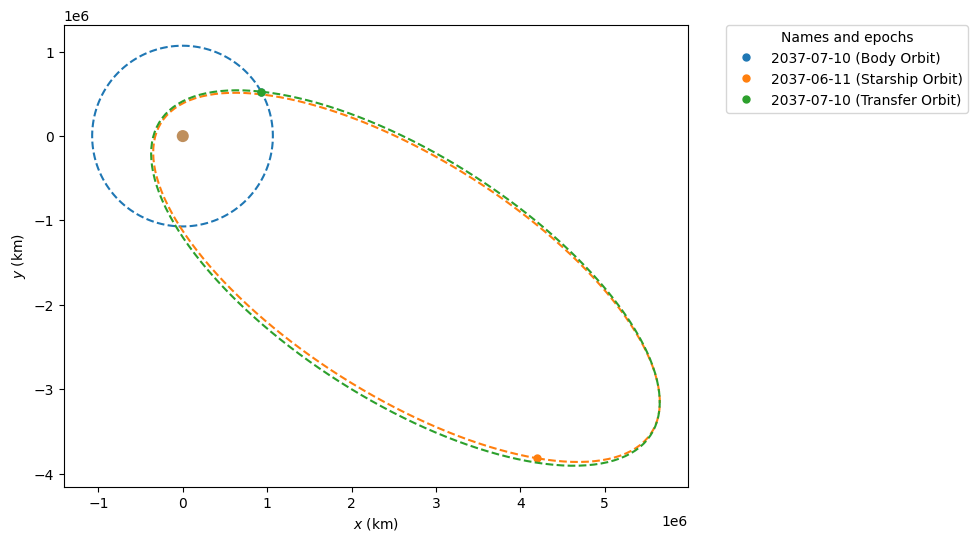

In [114]:



plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
plotter.plot(body_flyby_orbit, label="Body Orbit")
plotter.plot(starship_orb, label="Starship Orbit")
plotter.plot(starship_flyby_orbit, label="Transfer Orbit")

In [115]:
def assist_possible_periods(spacecraft_orb, body_orb, body, r_p_min=10*u.km, r_p_max=5000*u.km, num_samples=500):#finds possible periods of orbit around attractor given flyby
    periods=np.zeros((num_samples,2))
    periaps=np.zeros((num_samples))
    attractor=spacecraft_orb.attractor
    flyby_dist=np.linalg.norm(spacecraft_orb.r-body_orb.r)
    if(flyby_dist)<4*body.R:
        rel_vel=spacecraft_orb.rv()[1]-body_orb.rv()[1]
        rel_speed=np.linalg.norm(rel_vel)
        r_ps = body.R + np.linspace(r_p_min.to(u.km).value, r_p_max.to(u.km).value, num=num_samples) * u.km
        rot_angs = 2 * np.arcsin(1 / ((r_ps * rel_speed**2 / body.k) + 1 * u.one))
        # Rotation axis in ecliptic plane
        axis = np.array([0, 0, 1.0])
        axis = axis / np.linalg.norm(axis)
        # Try both rotation directions (leading/trailing side flybys)
        for j,sign in enumerate([1,-1]):
            for i, rot_ang in enumerate(rot_angs):
                # Rotate the relative velocity
                rot = scipyRot.from_rotvec(sign * axis * rot_ang.value)
                rel_vel_out = rot.apply(rel_vel.value) * u.km / u.s
                
                # Calculate post-assist velocity in attractor frame
                post_assist_vel = rel_vel_out + body_orb.rv()[1]
                
                # Create orbit from post-assist state
                test_orb = Orbit.from_vectors(
                    attractor, 
                    body_orb.r, 
                    post_assist_vel, 
                    spacecraft_orb.epoch,
                    plane=Planes.EARTH_ECLIPTIC
                )
                periods[i][j]=test_orb.period.to(u.day).value
                periaps[i]=r_ps[i].to(u.km).value
        return (periods,periaps)
                
                
    else:
        print(f"Trajectory does not fly past {body} closely enough - misses by {flyby_dist.to(u.km):.1f}")
        return None

In [116]:
def resonance_search(spacecraft_orb,body,r_p_min=10*u.km, r_p_max=5000*u.km, lower=True, numerator_prioritize=True, max_numerator=9,sim_start_date=time.Time("2037-06-11 00:01", scale="utc").tdb):
    used_orbit=deepcopy(spacecraft_orb)
    attractor=spacecraft_orb.attractor
    galilean_orbs=get_galilean_orbs(sim_start_date,sim_start_date+10*u.day)
    prelim_body_orb= galilean_orbs[body].propagate(used_orbit.epoch)
    postflyby_data=assist_possible_periods(used_orbit, prelim_body_orb, body,r_p_min=r_p_min, r_p_max=r_p_max,num_samples=5000)
    possible_resonances=[]
    if postflyby_data is not None:
        ##Check which side gives lower periods
        trailing_mean_period = np.mean(postflyby_data[:][0])
        leading_mean_period = np.mean(postflyby_data[0][:, 1])
        if trailing_mean_period < leading_mean_period:
            lower_side = 0  # Trailing side (sign=1)
            # print("Trailing side flybys give lower periods")
        else:
            lower_side = 1  # Leading side (sign=-1)
            # print("Leading side flybys give lower periods")

        side=lower_side if lower else 1-lower_side

        sign=int((-1)**(side))

        
        #generate allowed resonances      
        pairs = np.array([(i, j)
                  for i in range(1, max_numerator + 1)
                  for j in range(1, max_numerator + 1)
                  if math.gcd(i, j) == 1], dtype=int)
        # optional: the fraction values
        vals = pairs[:, 0] / pairs[:, 1]
        
        possible_resonant_periods = vals*prelim_body_orb.period.to(u.day)
        for i,period in enumerate(postflyby_data[0][:,side]):
            for j,test_period in enumerate(possible_resonant_periods):
                t_ratio=(((period*u.day)/test_period).to(u.one)).value
                if abs(1-t_ratio)<0.001:
                    # print(f"At {test_period:.1f} ie {pairs[j]} with flyby at {postflyby_data[1][i]*u.km-body.R.to(u.km)}")
                    possible_resonances.append((pairs[j], postflyby_data[1][i]*u.km-body.R.to(u.km)))
        # print(possible_resonances)
        
        groups = defaultdict(list)

        for frac_arr, rp in possible_resonances:
            key = tuple(frac_arr.tolist())      # e.g. (5, 7)
            groups[key].append(rp.to(u.km))     # keep as Quantity
        # one averaged periapsis per resonance fraction
        averaged = []
        for key, rps in groups.items():
            rp_mean = np.mean(u.Quantity(rps))  # Quantity mean, stays in km
            averaged.append((np.array(key, dtype=int), rp_mean, len(rps)))         
        
        if numerator_prioritize:#pick the resonance with the lowest numerator
            averaged.sort(key=lambda x: (x[0][0], x[1].value))  # Sort by numerator, then by periapsis
        h_p=averaged[0][1]
        chosen_resonance=averaged[0][0]
        
        tof=prelim_body_orb.period * (chosen_resonance[0])
        # print(f"Time of flight is {tof.to(u.day):.1f}, which is {chosen_resonance[0]} times the period of the moon.")
        arrival_date=used_orbit.epoch + tof
        target_orb=prelim_body_orb.propagate(arrival_date)
        print(f"Going for {chosen_resonance} resonance with periapsis at {h_p}, time till next encounter is {tof.to(u.day):.2f}")
        print(f"Flyby v inf speed is {np.linalg.norm(used_orbit.v-prelim_body_orb.v):.2f}")
        simple_ecliptic_vector,dummy2=ecliptic_slingshot(used_orbit,prelim_body_orb,body,h_p,1*sign)
        
        #find actual transfer
        print(f"Spacecraft does {chosen_resonance[1]-1} complete orbits before arriving, {body} does {chosen_resonance[0]-1}.")
        # print(f"Period of spacecraft orbit should be {(tof/chosen_resonance[1]).to(u.day):.1f}, actually is {dummy2.period.to(u.day):.1f}")
        # plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)       
        # plotter.plot(spacecraft_orb,label='initial_orb')
        # plotter.plot(target_orb,label='destination')
        # plotter.plot(dummy2.propagate(target_orb.epoch),label='ecliptic screwup')
        print(f"Arrives with distance of {np.linalg.norm(dummy2.propagate(target_orb.epoch).r-target_orb.r):.2f}")
        if dummy2.r_p.to(u.km)<1.05*attractor.R.to(u.km):
            print(f"Orbit crashes into {attractor}")
        return dummy2,tof

    else:
        print("Ending resonance search.")
        return None

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



In [117]:
resonance_search(starship_flyby_orbit,Ganymede,lower=True)

Going for [4 1] resonance with periapsis at 745.1740348069615 km, time till next encounter is 28.62 d
Flyby v inf speed is 11.82 km / s
Spacecraft does 0 complete orbits before arriving, Ganymede (●) does 3.
Arrives with distance of 75.85 km


(288584 x 5106735 km x 2.4 deg orbit around Jupiter (♃) at epoch 2037-07-10 00:22:52.681 (TDB),
 <Quantity 2473143.82751687 s>)

In [118]:
def multiple_resonances(spacecraft_orb, body, num_flybys, lower=False):
    active_orb=deepcopy(spacecraft_orb)
    orbits_so_far=[]
    for f in range(num_flybys):
        print(f"Flyby {f+1}")
        orbits_so_far.append(active_orb)
        try:
            dorb,time=resonance_search(active_orb,body,lower=lower)
            active_orb=dorb.propagate(time)
            continue
        except Exception as e:
            print(f"Failed to find resonance: {e}")
    orbits_so_far.append(active_orb)
    return orbits_so_far

In [120]:
orbits=multiple_resonances(starship_flyby_orbit,Ganymede,8,lower=True)

Flyby 1
Going for [4 1] resonance with periapsis at 745.1740348069615 km, time till next encounter is 28.62 d
Flyby v inf speed is 11.82 km / s
Spacecraft does 0 complete orbits before arriving, Ganymede (●) does 3.
Arrives with distance of 75.85 km
Flyby 2
Going for [3 1] resonance with periapsis at 821.0372074414884 km, time till next encounter is 21.47 d
Flyby v inf speed is 11.82 km / s
Spacecraft does 0 complete orbits before arriving, Ganymede (●) does 2.
Arrives with distance of 17.22 km
Flyby 3
Going for [5 2] resonance with periapsis at 1995.419083816763 km, time till next encounter is 35.78 d
Flyby v inf speed is 11.82 km / s
Spacecraft does 1 complete orbits before arriving, Ganymede (●) does 4.
Arrives with distance of 429.40 km
Flyby 4
Going for [2 1] resonance with periapsis at 633.874774954991 km, time till next encounter is 14.31 d
Flyby v inf speed is 11.82 km / s
Spacecraft does 0 complete orbits before arriving, Ganymede (●) does 1.
Arrives with distance of 265.16 km

1.8488080730284862


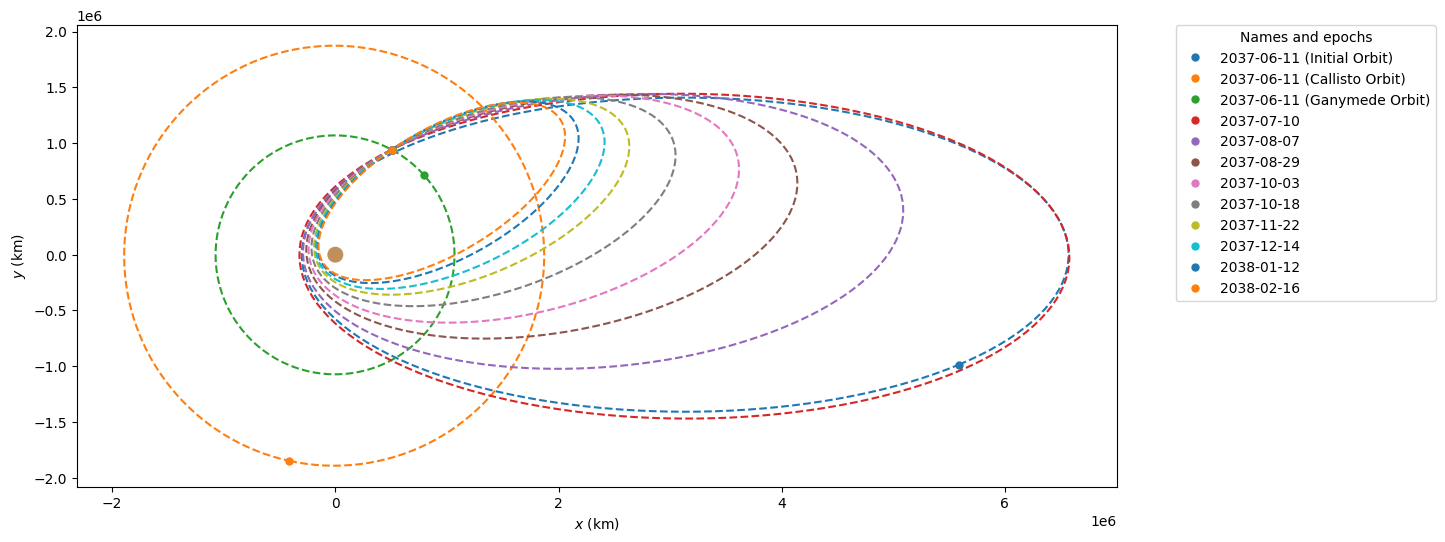

In [121]:
plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
# plotter.plot(starship_flyby_orbit)
plotter.plot(starship_orb,label="Initial Orbit")
plotter.plot(callisto_orb,label="Callisto Orbit")
plotter.plot(ganymede_orb,label="Ganymede Orbit")
print((orbits[-1].r_p.to(u.km)/Jupiter.R.to(u.km)).value)
for orbit in orbits:
    plotter.plot(orbit)   

In [122]:
#callisto raising block
post_ganymede_starship_orb=orbits[-1]
print(post_ganymede_starship_orb.ecc)
print(post_ganymede_starship_orb.a.to(u.km))

0.8936041158942988
1242294.1720719244 km


In [123]:

callisto_search_time=post_ganymede_starship_orb.epoch
callisto_orb=callisto_orb.propagate(callisto_search_time)
transfer_to_callisto=get_single_burn_elliptical_hohmann_brute_force(
    callisto_orb,
    post_ganymede_starship_orb,
    max_depature_wait=50*u.day,
    tof_step=0.2*u.day,
    min_tof=3*u.day,
    max_tof=100*u.day,
    retrograde_only=True
)

Best dv: 115.56708366320223 m / s
Refining search...
Best dv: 46.65053232465838 m / s


In [124]:
body_flyby_orbit=transfer_to_callisto[2]
tof_to_callisto=transfer_to_callisto[-1]
starship_flyby_orbit=transfer_to_callisto[1].propagate(tof_to_callisto-0.06*u.day)


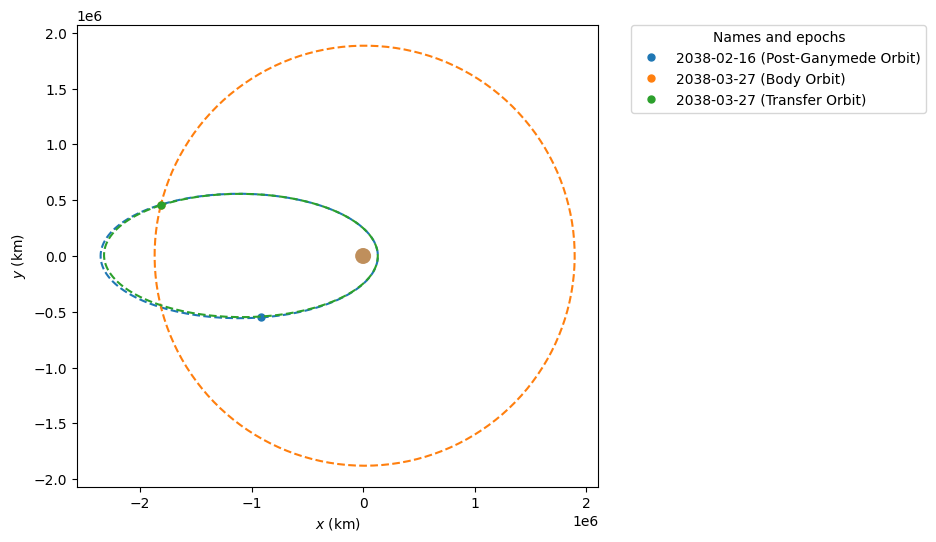

In [125]:
plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
# plotter.plot(post_ganymede_starship_orb.propagate(3.7*u.day), label="Post-Ganymede Orbit")
plotter.plot(post_ganymede_starship_orb, label="Post-Ganymede Orbit")
plotter.plot(body_flyby_orbit, label="Body Orbit")
plotter.plot(starship_flyby_orbit, label="Transfer Orbit")
# plotter.plot(transfer[-1], label="Periapsis Orbit") 

In [130]:
orbits_post_callisto=multiple_resonances(starship_flyby_orbit,Callisto,5,lower=False)

Flyby 1


Going for [3 5] resonance with periapsis at 176.20024004800942 km, time till next encounter is 50.05 d
Flyby v inf speed is 7.15 km / s
Spacecraft does 4 complete orbits before arriving, Callisto (○) does 2.
Arrives with distance of 259.23 km
Flyby 2
Going for [2 3] resonance with periapsis at 1440.420084016803 km, time till next encounter is 33.36 d
Flyby v inf speed is 7.15 km / s
Spacecraft does 2 complete orbits before arriving, Callisto (○) does 1.
Arrives with distance of 130.48 km
Flyby 3
Going for [3 4] resonance with periapsis at 1492.8255651130225 km, time till next encounter is 50.05 d
Flyby v inf speed is 7.15 km / s
Spacecraft does 3 complete orbits before arriving, Callisto (○) does 2.
Arrives with distance of 472.34 km
Flyby 4
Going for [5 6] resonance with periapsis at 2507.49549909982 km, time till next encounter is 83.41 d
Flyby v inf speed is 7.15 km / s
Spacecraft does 5 complete orbits before arriving, Callisto (○) does 4.
Arrives with distance of 238.95 km
Flyby 5

5.84217738110853
46.812311910386725


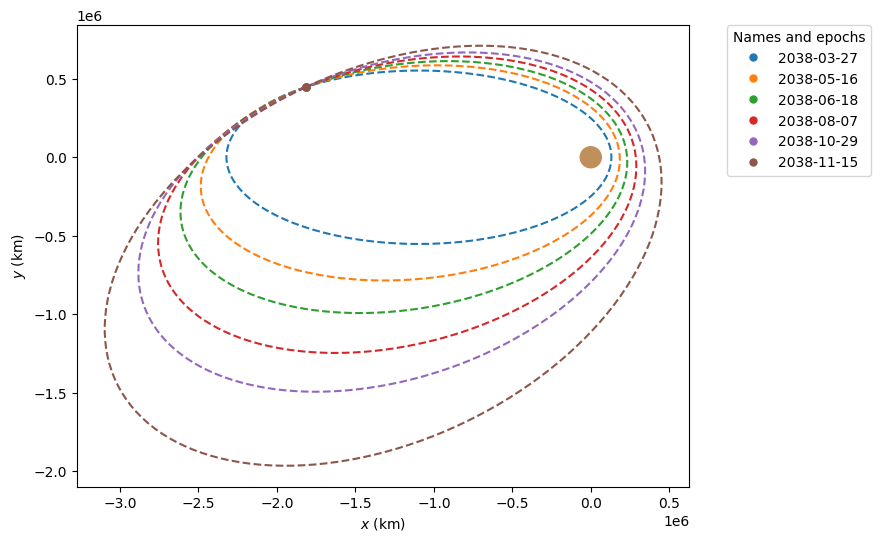

In [131]:
plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
for orbit in orbits_post_callisto:
    plotter.plot(orbit)   
print((orbits_post_callisto[-1].r_p/Jupiter.R).to(u.one))
print((orbits_post_callisto[-1].r_a/Jupiter.R).to(u.one))

In [133]:
#Io searching block
post_callisto_starship_orb=orbits_post_callisto[-1]

io_search_time=post_callisto_starship_orb.epoch
io_orb=io_orb.propagate(io_search_time)
transfer_to_io=get_single_burn_elliptical_hohmann_brute_force(
    io_orb,
    post_callisto_starship_orb,
    max_depature_wait=20*u.day,
    tof_step=0.1*u.day,
    min_tof=2*u.day,
    max_tof=40*u.day,
    retrograde_only=False
)

Best dv: 69.84750467396574 m / s
Refining search...
Best dv: 63.715537568964805 m / s


In [134]:
print(transfer_to_io[1].epoch)
print(transfer_to_io[-1])

2038-11-28 06:17:14.216
12.6 d


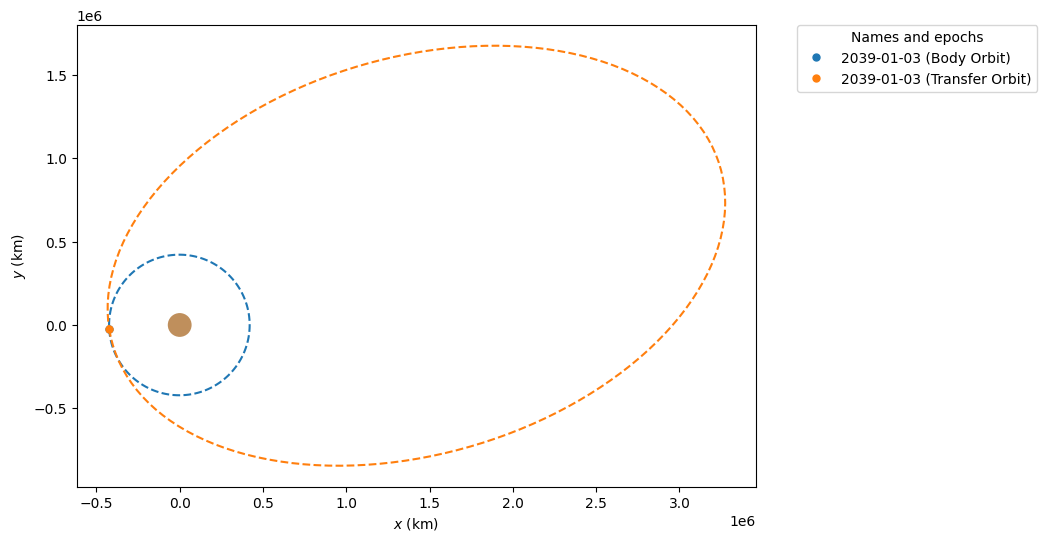

In [140]:
plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
# plotter.plot(post_callisto_starship_orb, label="Post-Callisto Orbit")
io_arrival_orb=transfer_to_io[2]
plotter.plot(transfer_to_io[2], label="Body Orbit")
starship_flyby_orbit_post_callisto=transfer_to_io[1].propagate(io_arrival_orb.epoch)
plotter.plot(starship_flyby_orbit_post_callisto, label="Transfer Orbit")

In [143]:
post_io_orbits=multiple_resonances(starship_flyby_orbit_post_callisto,Io,6,lower=True)

Flyby 1
Going for [8 1] resonance with periapsis at 1324.129825965193 km, time till next encounter is 14.17 d
Flyby v inf speed is 6.13 km / s
Spacecraft does 0 complete orbits before arriving, Io (☽) does 7.
Arrives with distance of 415.76 km
Flyby 2
Going for [6 1] resonance with periapsis at 206.64532906581312 km, time till next encounter is 10.63 d
Flyby v inf speed is 6.14 km / s
Spacecraft does 0 complete orbits before arriving, Io (☽) does 5.
Arrives with distance of 763.96 km
Flyby 3
Going for [5 1] resonance with periapsis at 1576.6743348669731 km, time till next encounter is 8.85 d
Flyby v inf speed is 6.13 km / s
Spacecraft does 0 complete orbits before arriving, Io (☽) does 4.
Arrives with distance of 423.93 km
Flyby 4
Going for [4 1] resonance with periapsis at 847.9885977195439 km, time till next encounter is 7.08 d
Flyby v inf speed is 6.12 km / s
Spacecraft does 0 complete orbits before arriving, Io (☽) does 3.
Arrives with distance of 193.96 km
Flyby 5
Going for [3 1] 

5.330697740629275
16.41384913347144


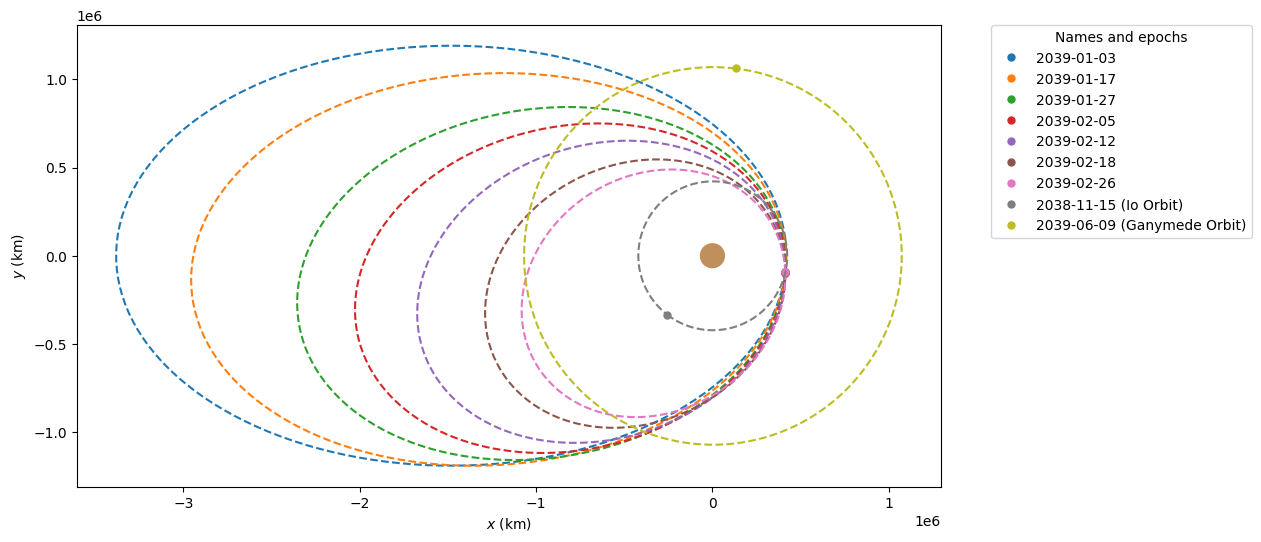

In [226]:
plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
for orbit in post_io_orbits:
    plotter.plot(orbit)   
plotter.plot(io_orb,label="Io Orbit")
plotter.plot(ganymede_orb,label="Ganymede Orbit")
print((post_io_orbits[-1].r_p/Jupiter.R).to(u.one))
print((post_io_orbits[-1].r_a/Jupiter.R).to(u.one))

In [150]:
post_io_starship_orb=post_io_orbits[-1]
ganymede_search_time=post_io_starship_orb.epoch
ganymede_orb=ganymede_orb.propagate(ganymede_search_time)
ganymede_search=get_single_burn_elliptical_hohmann_brute_force(
    ganymede_orb,
    post_io_starship_orb,
    max_depature_wait=20*u.day,
    tof_step=0.1*u.day,
    min_tof=2*u.day,
    max_tof=40*u.day,
    retrograde_only=True
)

Best dv: 347.51387369507484 m / s
Refining search...
Best dv: 346.87750137256603 m / s


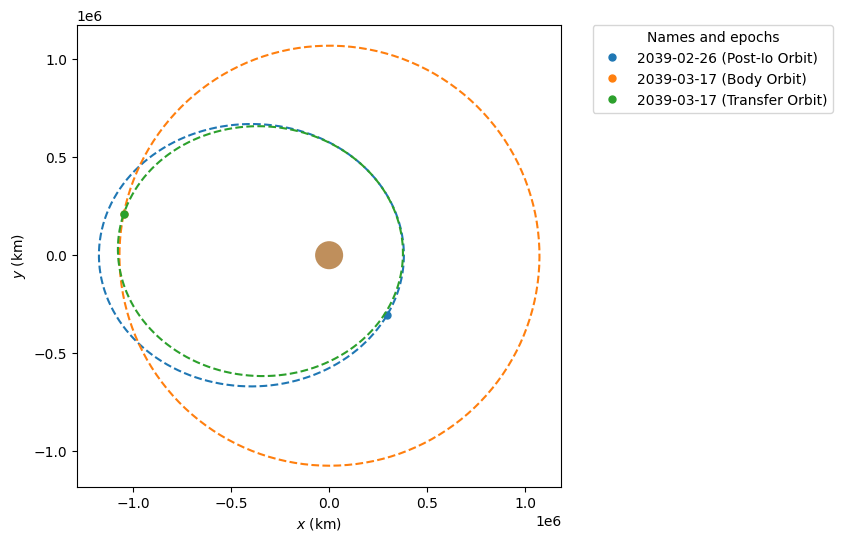

In [151]:
ganymede_2_flyby_orbit=ganymede_search[1].propagate(ganymede_search[-1])
ganymede_2_arrival_orb=ganymede_search[2]
plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
plotter.plot(post_io_starship_orb, label="Post-Io Orbit")
plotter.plot(ganymede_2_arrival_orb, label="Body Orbit")
starship_flyby_orbit_post_io=ganymede_search[1].propagate(ganymede_2_arrival_orb.epoch)
plotter.plot(starship_flyby_orbit_post_io, label="Transfer Orbit")  

In [168]:
orbits_post_ganymede_2=multiple_resonances(starship_flyby_orbit_post_io,Ganymede,2,lower=False)

Flyby 1
Going for [2 3] resonance with periapsis at 192.6705341068215 km, time till next encounter is 14.31 d
Flyby v inf speed is 3.19 km / s
Spacecraft does 2 complete orbits before arriving, Ganymede (●) does 1.
Arrives with distance of 183.23 km
Flyby 2
Going for [4 5] resonance with periapsis at 2739.077815563112 km, time till next encounter is 28.62 d
Flyby v inf speed is 3.19 km / s
Spacecraft does 4 complete orbits before arriving, Ganymede (●) does 3.
Arrives with distance of 217.41 km


8.672240430753533
17.13707323077966


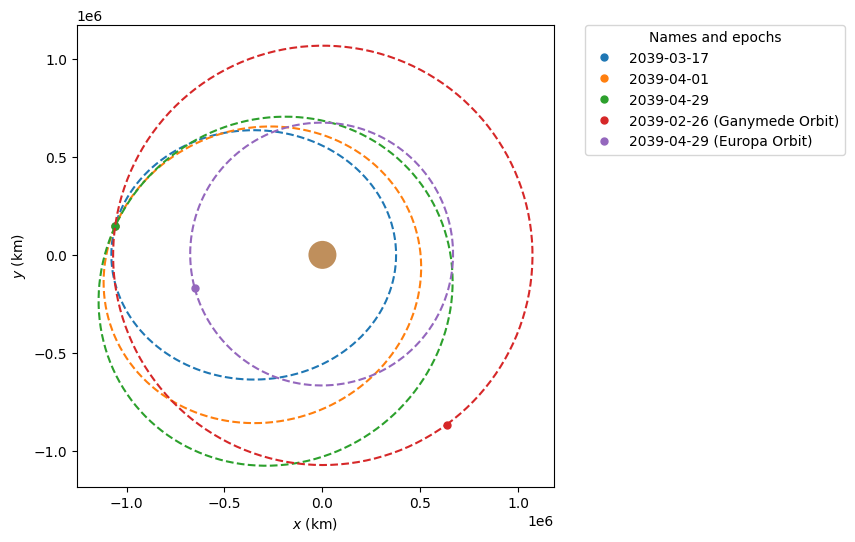

In [169]:
plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
for orbit in orbits_post_ganymede_2:
    plotter.plot(orbit)   
plotter.plot(ganymede_orb,label="Ganymede Orbit")
plotter.plot(europa_orb,label="Europa Orbit")
print((orbits_post_ganymede_2[-1].r_p/Jupiter.R).to(u.one))
print((orbits_post_ganymede_2[-1].r_a/Jupiter.R).to(u.one))

In [ ]:
post_ganymede_2_starship_orb=orbits_post_ganymede_2[-1]
europa_search_time=post_ganymede_2_starship_orb.epoch
europa_orb=europa_orb.propagate(europa_search_time)
europa_search=get_single_burn_elliptical_hohmann_brute_force(
    europa_orb,
    post_ganymede_2_starship_orb,
    max_depature_wait=20*u.day,
    tof_step=0.1*u.day,
    min_tof=2*u.day,
    max_tof=40*u.day,
    retrograde_only=True
)

Best dv: 124.77768529155401 m / s
Refining search...
Best dv: 123.6423133078863 m / s


In [157]:
europa_flyby_orb=europa_search[2]
starship_europa_flyby_1=europa_search[1].propagate(europa_flyby_orb.epoch)
tof_to_europa=europa_search[-1]

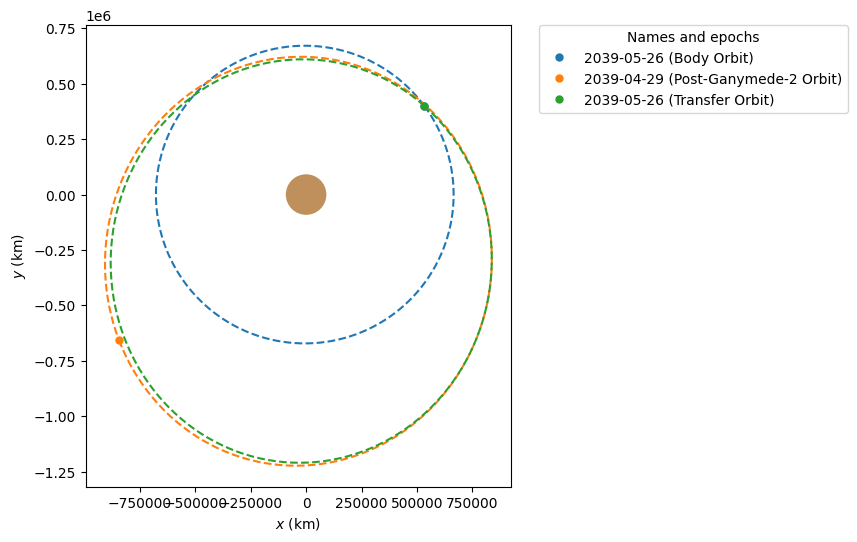

In [ ]:
plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
plotter.plot(europa_flyby_orb, label="Europa Orbit")
plotter.plot(post_ganymede_2_starship_orb, label="Post-Ganymede-2 Orbit")
plotter.plot(starship_europa_flyby_1, label="Transfer Orbit")   

In [171]:
orbits_post_europa_1=multiple_resonances(starship_europa_flyby_1,Europa,1,lower=True)

Flyby 1
Going for [4 3] resonance with periapsis at 1047.129425885177 km, time till next encounter is 14.20 d
Flyby v inf speed is 3.50 km / s
Spacecraft does 2 complete orbits before arriving, Europa (☾) does 3.
Arrives with distance of 56.59 km


8.158467490620433
14.58229633683241


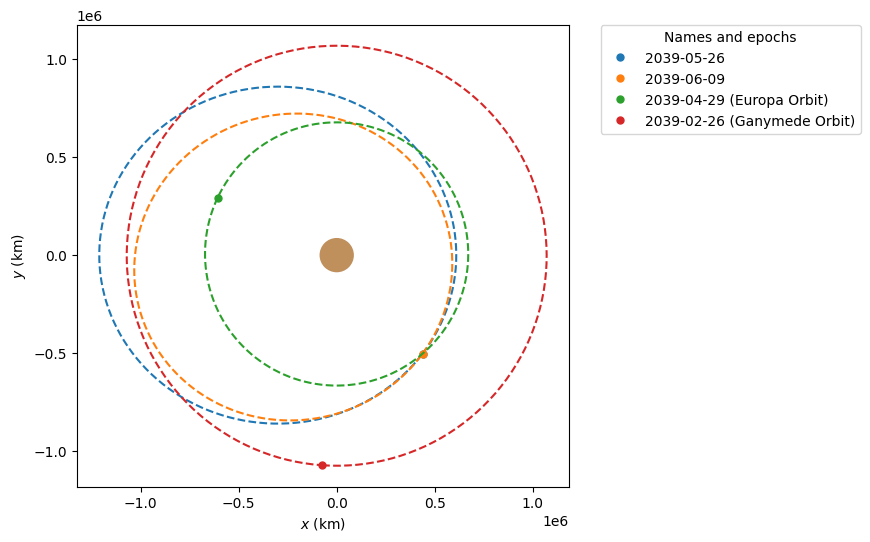

In [172]:
plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
for orbit in orbits_post_europa_1:
    plotter.plot(orbit)
plotter.plot(europa_orb,label="Europa Orbit")
plotter.plot(ganymede_orb,label="Ganymede Orbit")
print((orbits_post_europa_1[-1].r_p/Jupiter.R).to(u.one))
print((orbits_post_europa_1[-1].r_a/Jupiter.R).to(u.one))

In [173]:
post_europa_1_starship_orb=orbits_post_europa_1[-1]
ganymede_search_time=post_europa_1_starship_orb.epoch
ganymede_orb=ganymede_orb.propagate(ganymede_search_time)
post_europa_1_search=get_single_burn_elliptical_hohmann_brute_force(
    ganymede_orb,
    post_europa_1_starship_orb,
    max_depature_wait=30*u.day,
    tof_step=0.1*u.day,
    min_tof=2*u.day,
    max_tof=40*u.day,
    retrograde_only=False
)

Best dv: 427.3611819491029 m / s
Refining search...
Best dv: 422.1968657385148 m / s


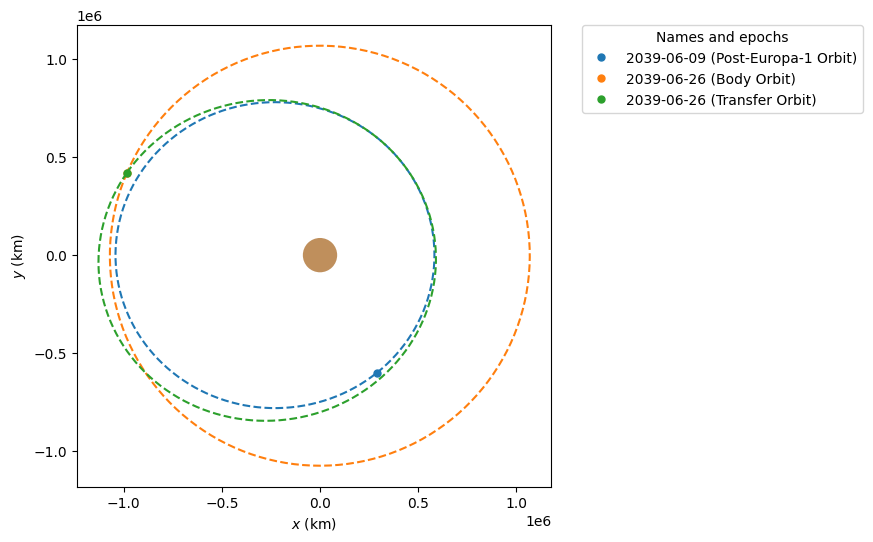

In [174]:
ganymede_3_flyby_orbit=post_europa_1_search[1].propagate(post_europa_1_search[-1])
ganymede_3_arrival_orb=post_europa_1_search[2]
plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
plotter.plot(post_europa_1_starship_orb, label="Post-Europa-1 Orbit")
plotter.plot(ganymede_3_arrival_orb, label="Body Orbit")
starship_flyby_orbit_post_europa_1=post_europa_1_search[1].propagate(ganymede_3_arrival_orb.epoch)
plotter.plot(starship_flyby_orbit_post_europa_1, label="Transfer Orbit")

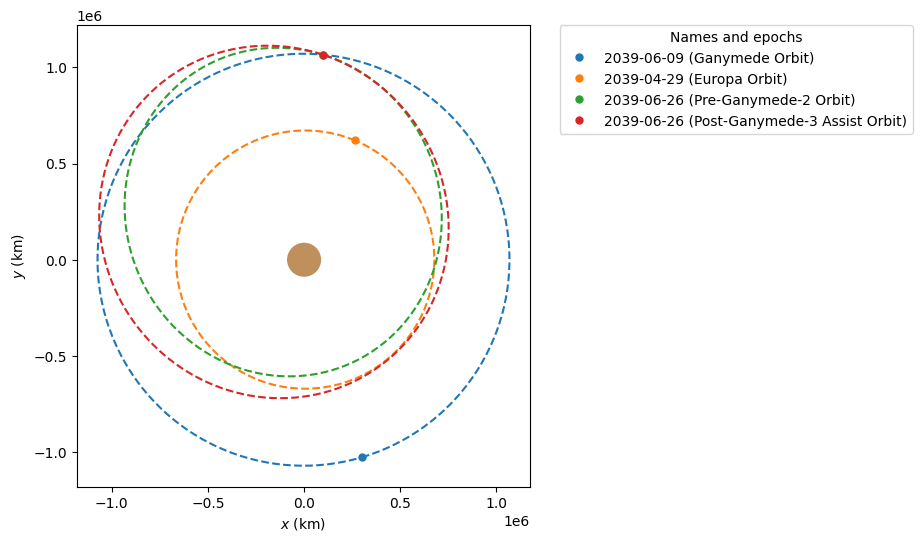

In [198]:
post_ganymede_3_assist_orb=ecliptic_slingshot(
    starship_flyby_orbit_post_europa_1,
    ganymede_3_arrival_orb,
    Ganymede,
    9000*u.km,
    1
)[1]

plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
plotter.plot(ganymede_orb,label="Ganymede Orbit")
plotter.plot(europa_orb,label="Europa Orbit")
plotter.plot(starship_flyby_orbit_post_europa_1,label="Pre-Ganymede-2 Orbit")
plotter.plot(post_ganymede_3_assist_orb, label="Post-Ganymede-3 Assist Orbit")


In [201]:
europa_final_encounter_orb=get_single_burn_elliptical_hohmann_brute_force(
    europa_orb,
    post_ganymede_3_assist_orb,
    max_depature_wait=20*u.day,
    tof_step=0.5*u.day,
    min_tof=2*u.day,
    max_tof=30*u.day,
    retrograde_only=False
)

Best dv: 204.78871367050886 m / s
Refining search...
Best dv: 184.58683837194292 m / s


In [220]:
print(europa_final_encounter_orb)

[<Quantity 184.58683837 m / s>, 664077 x 1138629 km x 2.9 deg orbit around Jupiter (♃) at epoch 2039-07-07 08:52:26.182 (TDB), 665064 x 676992 km x 2.0 deg orbit around Jupiter (♃) at epoch 2039-07-11 19:40:27.182 (TDB), <Time object: scale='tdb' format='iso' value=2039-07-11 19:40:26.182>, <Quantity 10.65 d>]


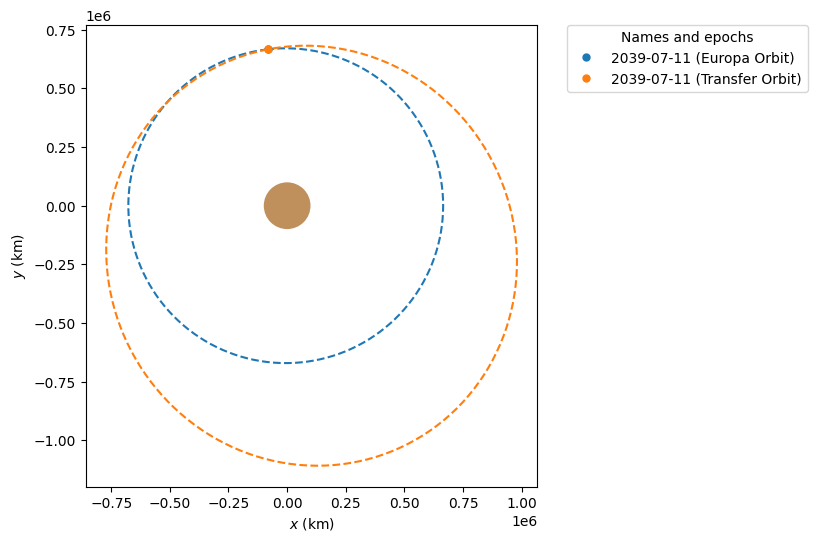

In [221]:
plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
plotter.plot(europa_final_encounter_orb[2], label="Europa Orbit")
arrival=europa_final_encounter_orb[1].propagate(europa_final_encounter_orb[2].epoch)
plotter.plot(arrival, label="Transfer Orbit")


In [223]:
print(np.linalg.norm(arrival.v-europa_final_encounter_orb[2].v))

2.0247939769175587 km / s


Going for [4 3] resonance with periapsis at 1758.3466693338669 km, time till next encounter is 14.20 d
Flyby v inf speed is 2.02 km / s
Spacecraft does 2 complete orbits before arriving, Europa (☾) does 3.
Arrives with distance of 27.30 km


(648316 x 977471 km x 2.9 deg orbit around Jupiter (♃) at epoch 2039-07-11 19:40:27.182 (TDB),
 <Quantity 1227272.57164272 s>)